In [47]:
import pandas as pd

In [48]:
# pip install ludwig[full]

In [49]:
# !pip install -U scikit-learn


In [50]:
url = 'https://raw.githubusercontent.com/john-adeojo/walmartdata/main/Walmart%20Store/TRAIN.csv'
df = pd.read_csv(url)
df.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


In [51]:
# Data set splitting
import numpy as np
import hashlib

def split_data(df):
  # Create a new column 'hash_val' that is the hash of the 'Store_id' column
  df['hash_val'] = df['Store_id'].apply(lambda x: int(hashlib.sha256(str(x).encode('utf-8')).hexdigest(), 16))

  # Use the 'hash_val' column to create a boolean mask for the holdout set
  is_holdout = df['hash_val'] % 10 < 2  # Approximately 20% will be in the holdout set

  # Create the holdout and train sets
  holdout_set = df[is_holdout].copy()
  train_set = df[~is_holdout].copy()

  # Add a 'set' column to each set
  holdout_set['set'] = 'hold_out'
  train_set['set'] = 'train'

  df_all = pd.concat([holdout_set, train_set], axis=0)

  return train_set, df_all

train_set, df_all = split_data(df)

In [52]:
def number_encode(df):
    # Convert 'Discount' column to binary
  df['Discount'] = df['Discount'].map({'Yes': 1, 'No': 0}).astype(int)

  # Encode Store Type
  df['Store_Type'] = df['Store_Type'].map({'S1': 0, 'S2': 1, 'S3': 2, 'S4': 4}).astype(int)

  # Encode Location_Type
  df['Location_Type'] = df['Location_Type'].map({'L1': 0, 'L2': 1, 'L3': 2, 'L4': 4, 'L5': 5}).astype(int)

  # Encode Location_Type
  df['Region_Code'] = df['Region_Code'].map({'R1': 0, 'R2': 1, 'R3': 2, 'R4': 4}).astype(int)

  # Convert 'Date' to datetime
  df['Date'] = pd.to_datetime(df['Date'])

  # Create 'DayOfWeek' and 'MonthOfYear'
  df['DayOfWeek'] = df['Date'].dt.dayofweek
  df['MonthOfYear'] = df['Date'].dt.month

  return df

train_set_encoded = number_encode(train_set)
all_set_encoded = number_encode(df_all)

In [53]:
from sklearn.preprocessing import StandardScaler

# Sequence Features
sequence_features = ['Sales', 'DayOfWeek', 'MonthOfYear', 'Store_Type', 'Location_Type', 'Region_Code']

# initialize a standard scaler
scaler = StandardScaler()

# copy the original Sales column to a new column Sales_original
train_set_encoded['Orders_original'] = train_set_encoded['#Order']
all_set_encoded['Orders_original'] = all_set_encoded['#Order']

# fit the scaler on the training set (excluding 'Sales' because we want to preserve it as the label)
scaler.fit(train_set_encoded[sequence_features])

# transform both the training set and the holdout set
train_set_encoded[sequence_features] = scaler.transform(train_set_encoded[sequence_features])
all_set_encoded[sequence_features] = scaler.transform(all_set_encoded[sequence_features])

# now add 'Sales' to the sequence_features list and fit and transform 'Sales' separately
scaler.fit(train_set_encoded[['#Order']])
train_set_encoded['#Order'] = scaler.transform(train_set_encoded[['#Order']])
all_set_encoded['#Order'] = scaler.transform(all_set_encoded[['#Order']])


In [54]:
all_set_encoded.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales,hash_val,set,DayOfWeek,MonthOfYear,Orders_original
3,T1000004,251,-0.223948,0.593594,-1.002040,2018-01-01,1,1,-1.517885,-1.272747,9017500930054051502567433507221030433242136850...,hold_out,-1.496987,-1.323177,23
10,T1000011,245,1.609495,-0.771205,-0.253714,2018-01-01,1,1,-1.085051,-0.850758,4999567512076337693454235053624426164377272585...,hold_out,-1.496987,-1.323177,36
24,T1000025,272,-0.223948,1.958393,-0.253714,2018-01-01,1,1,-0.685513,-0.513469,1285565998246243054441738250712298189648882471...,hold_out,-1.496987,-1.323177,48
28,T1000029,268,-0.835095,-0.088805,-1.002040,2018-01-01,1,1,0.213450,0.783158,6300121100003475510973824048995146962150913489...,hold_out,-1.496987,-1.323177,75
30,T1000031,267,1.609495,-0.088805,-1.002040,2018-01-01,1,1,-0.652218,-0.266335,6277985557774950910508828507924182645375487057...,hold_out,-1.496987,-1.323177,49


In [55]:
import pandas as pd
import numpy as np

def transform_data(df):

  # Sort DataFrame by 'Store_id' and 'Date'
  df.sort_values(['Store_id', 'Date'], inplace=True)

  # List of sequence features
  sequence_features = ['Orders_original', 'Sales', '#Order', 'Discount', 'DayOfWeek', 'MonthOfYear', 'Holiday', 'Store_Type', 'Location_Type', 'Region_Code']

  # Window size for features and labels (3 days for example)
  feature_window_size = 360
  label_window_size = 30

  # List to store sequences
  sequences = []

  # Generate sequences for each store
  for store_id in df['Store_id'].unique():
      df_store = df[df['Store_id'] == store_id]

      # Check if store has enough data for the window
      if len(df_store) >= (feature_window_size + label_window_size):
          sequence = {feature: ' '.join(map(str, df_store[feature].iloc[-feature_window_size-label_window_size:-label_window_size].values)) for feature in sequence_features}
          sequence['Order_sequence_label'] = ' '.join(map(str, df_store['Orders_original'].iloc[-label_window_size:].values))
          sequence['Order_sequence_label_date'] = ' '.join(map(str, df_store['Date'].iloc[-label_window_size:].dt.date.values))
          sequence['Store_id'] = store_id
          sequences.append(sequence)

  # Convert list of sequences to DataFrame
  df_sequences = pd.DataFrame(sequences)

  df_sequences.rename(columns={'#Order': 'Order'}, inplace=True)

  # Split 'Sales_sequence_label' and 'Sales_sequence_label_date' into list of values
  df_sequences['Order_sequence_label'] = df_sequences['Order_sequence_label'].str.split(' ')
  df_sequences['Order_sequence_label_date'] = df_sequences['Order_sequence_label_date'].str.split(' ')

  # Convert list into separate columns
  sales_columns = df_sequences['Order_sequence_label'].apply(lambda x: [float(i) for i in x]).apply(pd.Series)
  sales_columns_date = df_sequences['Order_sequence_label_date'].apply(pd.Series)

  # Calculate the average of 'Order_sequence_label' for each row
  df_sequences['Order_sequence_label_avg'] = sales_columns.mean(axis=1)

  # Rename columns
  sales_columns = sales_columns.rename(columns = lambda x : 'Order_sequence_label_' + str(df_sequences['Order_sequence_label_date'].iloc[0][x]))

  # Concatenate the sales_columns dataframe with the original dataframe
  df_sequences = pd.concat([df_sequences[:], sales_columns[:]], axis=1)

  # Drop the original 'Sales_sequence_label' and 'Sales_sequence_label_date' columns
  df_sequences = df_sequences.drop(['Order_sequence_label', 'Order_sequence_label_date'], axis=1)

  return df_sequences

df_sequences_train = transform_data(train_set_encoded)
df_sequences_all = transform_data(all_set_encoded)
df_sequences_train.head()


,Orders_original,Sales,Order,Discount,DayOfWeek,MonthOfYear,Holiday,Store_Type,Location_Type,Region_Code,...,Order_sequence_label_2019-05-22,Order_sequence_label_2019-05-23,Order_sequence_label_2019-05-24,Order_sequence_label_2019-05-25,Order_sequence_label_2019-05-26,Order_sequence_label_2019-05-27,Order_sequence_label_2019-05-28,Order_sequence_label_2019-05-29,Order_sequence_label_2019-05-30,Order_sequence_label_2019-05-31
0,37 51 48 65 49 56 42 54 62 75 62 70 41 59 48 6...,-1.100107566179632 -0.6647864265245274 -0.7656...,-1.05175656594264 -0.585627988170087 -0.685512...,0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 ...,-1.496986940431663 -0.9963743278180932 -0.4957...,-0.14651292489075562 -0.14651292489075562 -0.1...,0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,-0.8350954358175171 -0.8350954358175171 -0.835...,0.5935940573910438 0.5935940573910438 0.593594...,-1.0020404903955336 -1.0020404903955336 -1.002...,...,57.0,69.0,54.0,65.0,39.0,53.0,57.0,69.0,66.0,62.0
1,96 103 101 106 93 111 84 90 109 111 103 118 10...,0.6890198633781252 1.0039990375696843 0.937002...,0.9126424403845477 1.145706729270824 1.0791169...,0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 ...,-1.496986940431663 -0.9963743278180932 -0.4957...,-0.14651292489075562 -0.14651292489075562 -0.1...,0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,1.6094947121395253 1.6094947121395253 1.609494...,-0.08880541016086488 -0.08880541016086488 -0.0...,-1.0020404903955336 -1.0020404903955336 -1.002...,...,152.0,128.0,132.0,159.0,111.0,121.0,124.0,128.0,126.0,122.0
2,66 61 57 53 65 47 76 67 67 73 47 42 72 70 61 6...,-0.10912332140587747 -0.32417131125050336 -0.4...,-0.08620451198520876 -0.2526790040468348 -0.38...,0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 ...,-1.496986940431663 -0.9963743278180932 -0.4957...,-0.14651292489075562 -0.14651292489075562 -0.1...,0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,-0.8350954358175171 -0.8350954358175171 -0.835...,-0.7712048777127735 -0.7712048777127735 -0.771...,-0.253713576852066 -0.253713576852066 -0.25371...,...,67.0,41.0,67.0,77.0,82.0,75.0,84.0,41.0,61.0,61.0
3,69 67 67 52 54 66 69 68 65 58 67 76 69 83 59 5...,0.13580605199346868 0.14788923441450308 0.1478...,0.013680183251766882 -0.05290961357288354 -0.0...,0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 ...,-1.496986940431663 -0.9963743278180932 -0.4957...,-0.14651292489075562 -0.14651292489075562 -0.1...,0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,-0.8350954358175171 -0.8350954358175171 -0.835...,-0.7712048777127735 -0.7712048777127735 -0.771...,0.4946133366914016 0.4946133366914016 0.494613...,...,75.0,60.0,57.0,84.0,69.0,72.0,68.0,64.0,67.0,64.0
4,38 80 76 69 77 66 39 85 86 85 96 102 49 96 73 ...,-1.1296623772364864 0.2536987237230206 0.12372...,-1.0184616675303146 0.3799240657873442 0.24674...,0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 ...,-1.496986940431663 -0.9963743278180932 -0.4957...,-0.14651292489075562 -0.14651292489075562 -0.1...,0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,1.6094947121395253 1.6094947121395253 1.609494...,-0.7712048777127735 -0.7712048777127735 -0.771...,-1.0020404903955336 -1.0020404903955336 -1.002...,...,74.0,85.0,82.0,45.0,100.0,85.0,87.0,105.0,110.0,103.0


In [56]:
# import pandas as pd
# import numpy as np

# def transform_data(df):

#   # Sort DataFrame by 'Store_id' and 'Date'
#   df.sort_values(['Store_id', 'Date'], inplace=True)

#   # List of sequence features
#   sequence_features = ['Orders_original', 'Sales', '#Order', 'Discount', 'DayOfWeek', 'MonthOfYear', 'Holiday', 'Store_Type', 'Location_Type', 'Region_Code']

#   # Window size for features and labels (3 days for example)
#   feature_window_size = 360
#   label_window_size = 30

#   # List to store sequences
#   sequences = []

#   # Generate sequences for each store
#   for store_id in df['Store_id'].unique():
#       df_store = df[df['Store_id'] == store_id]

#       # Check if store has enough data for the window
#       if len(df_store) >= (feature_window_size + label_window_size):
#           sequence = {feature: ' '.join(map(str, df_store[feature].iloc[-feature_window_size-label_window_size:-label_window_size].values)) for feature in sequence_features}
#           sequence['Order_sequence_label'] = ' '.join(map(str, df_store['Orders_original'].iloc[-label_window_size:].values))
#           sequence['Order_sequence_label_date'] = ' '.join(map(str, df_store['Date'].iloc[-label_window_size:].dt.date.values))
#           sequence['Store_id'] = store_id
#           sequences.append(sequence)

#   # Convert list of sequences to DataFrame
#   df_sequences = pd.DataFrame(sequences)

#   df_sequences.rename(columns={'#Order': 'Order'}, inplace=True)

#   # Split 'Sales_sequence_label' and 'Sales_sequence_label_date' into list of values
#   df_sequences['Order_sequence_label'] = df_sequences['Order_sequence_label'].str.split(' ')
#   df_sequences['Order_sequence_label_date'] = df_sequences['Order_sequence_label_date'].str.split(' ')

#   # Determine the maximum length of sales sequences
#   max_length = df_sequences['Order_sequence_label'].str.len().max()

#   # Convert list into separate columns
#   sales_columns = df_sequences['Order_sequence_label'].apply(pd.Series)
#   sales_columns_date = df_sequences['Order_sequence_label_date'].apply(pd.Series)

#   # Rename columns
#   sales_columns = sales_columns.rename(columns = lambda x : 'Order_sequence_label_' + str(df_sequences['Order_sequence_label_date'].iloc[0][x]))

#   # Concatenate the sales_columns dataframe with the original dataframe
#   df_sequences = pd.concat([df_sequences[:], sales_columns[:]], axis=1)

#   # Drop the original 'Sales_sequence_label' and 'Sales_sequence_label_date' columns
#   df_sequences = df_sequences.drop(['Order_sequence_label', 'Order_sequence_label_date'], axis=1)

#   return df_sequences

# df_sequences_train = transform_data(train_set_encoded)
# df_sequences_all = transform_data(all_set_encoded)
# df_sequences_train.head()

In [68]:
import requests
import yaml
from ludwig.api import LudwigModel

# URL of the raw YAML file in the GitHub repository
url = 'https://raw.githubusercontent.com/john-adeojo/walmartdata/main/Walmart%20Store/parallel_cnn.yaml'

# Send a GET request to the URL
response = requests.get(url)

# Raise an exception if the request was unsuccessful
response.raise_for_status()

# Load the YAML data from the response text
config = yaml.safe_load(response.text)

# Now you can use the config dictionary to initialize the Ludwig model
model = LudwigModel(config=config)
results = model.train(dataset=df_sequences_train)

In [69]:
# from ludwig.api import LudwigModel
# from ludwig.visualize import learning_curves
# from google.colab import drive
# import yaml

# # Mount your Google Drive
# drive.mount('/content/drive')

# # URL of the raw YAML file in the GitHub repository
# url = 'https://raw.githubusercontent.com/john-adeojo/walmartdata/main/Walmart%20Store/transformers.yaml'

# # Send a GET request to the URL
# response = requests.get(url)

# # Raise an exception if the request was unsuccessful
# response.raise_for_status()

# # Load the YAML data from the response text
# config = yaml.safe_load(response.text)

# # Set your output directory path
# output_dir = "/content/drive/My Drive/Data-Centric Solutions/07. Blog Posts/deep learning/results"

# # Set up your experiment
# model = LudwigModel(config=config)
# experiment_results = model.experiment(
#   dataset=df_sequences_train,
#   output_directory=output_dir
# )


In [70]:
# %matplotlib inline

# !ludwig visualize --visualization learning_curves \
#   --output_feature_name Sales_sequence_label_2019-05-31 \
#   --training_statistics "/content/drive/My%20Drive/Data-Centric%20Solutions/07.%20Blog%20Posts/deep%20learning/results/experiment_run/training_statistics.json"

In [71]:
predictions, _ = model.predict(dataset=df_sequences_all)
predictions.head()

,Order_sequence_label_2019-05-02_predictions,Order_sequence_label_2019-05-03_predictions,Order_sequence_label_2019-05-04_predictions,Order_sequence_label_2019-05-05_predictions,Order_sequence_label_2019-05-06_predictions,Order_sequence_label_2019-05-07_predictions,Order_sequence_label_2019-05-08_predictions,Order_sequence_label_2019-05-09_predictions,Order_sequence_label_2019-05-10_predictions,Order_sequence_label_2019-05-11_predictions,...,Order_sequence_label_2019-05-23_predictions,Order_sequence_label_2019-05-24_predictions,Order_sequence_label_2019-05-25_predictions,Order_sequence_label_2019-05-26_predictions,Order_sequence_label_2019-05-27_predictions,Order_sequence_label_2019-05-28_predictions,Order_sequence_label_2019-05-29_predictions,Order_sequence_label_2019-05-30_predictions,Order_sequence_label_2019-05-31_predictions,Order_sequence_label_avg_predictions
0,87.768280,86.212959,113.621048,86.905029,65.689819,64.295609,59.925098,59.064697,62.327011,67.831772,...,53.640568,58.537106,73.409081,75.587044,64.039085,75.075813,57.881626,56.111252,55.539551,69.183029
1,112.494003,111.956123,144.008453,108.785034,81.946266,79.857376,74.982414,74.960777,77.734215,85.311783,...,68.907860,75.365601,92.806396,98.280632,79.310188,96.328087,69.250793,69.115974,67.471458,87.378387
2,172.346970,167.826736,195.561401,176.910339,144.460968,132.715576,119.932243,121.127144,120.337166,151.205124,...,112.935745,114.346375,133.254684,139.135178,116.077972,123.357254,127.264313,103.104088,105.625786,134.621140
3,92.306152,91.122734,118.342056,89.903496,66.347069,65.516006,61.669155,61.906540,64.883316,70.619965,...,57.865318,62.899979,78.615013,80.905106,66.544708,80.251335,59.302074,58.113911,57.418190,72.459831
4,93.977692,88.323006,113.477814,90.355415,70.189400,70.323357,66.192039,64.551140,68.078903,79.230438,...,62.457516,68.219963,82.382065,81.382607,68.618279,78.337608,69.671219,61.532223,62.717880,75.390282


In [73]:
#drop order sequence_label-avg
predictions = predictions.drop(columns=['Order_sequence_label_avg_predictions'])

# First, let's reset the index of predictions dataframe to have the store id as a column
predictions = predictions.reset_index().rename(columns={'index': 'Store_id'})

# Now we convert the wide format dataframe to a long format dataframe
predictions_melted = predictions.melt(id_vars=['Store_id'], var_name='Date', value_name='Predicted_Orders')

# The 'Date' column is currently a string in the format 'Sales_sequence_label_YYYY-MM-DD_predictions', let's extract the date
predictions_melted['Date'] = predictions_melted['Date'].str.extract('(\d{4}-\d{2}-\d{2})')

# Convert 'Date' column back to datetime format
predictions_melted['Date'] = pd.to_datetime(predictions_melted['Date'])

# Now, let's merge this with the original dataframe
df_analysis = pd.merge(df_all, predictions_melted, on=['Store_id', 'Date'], how='left')

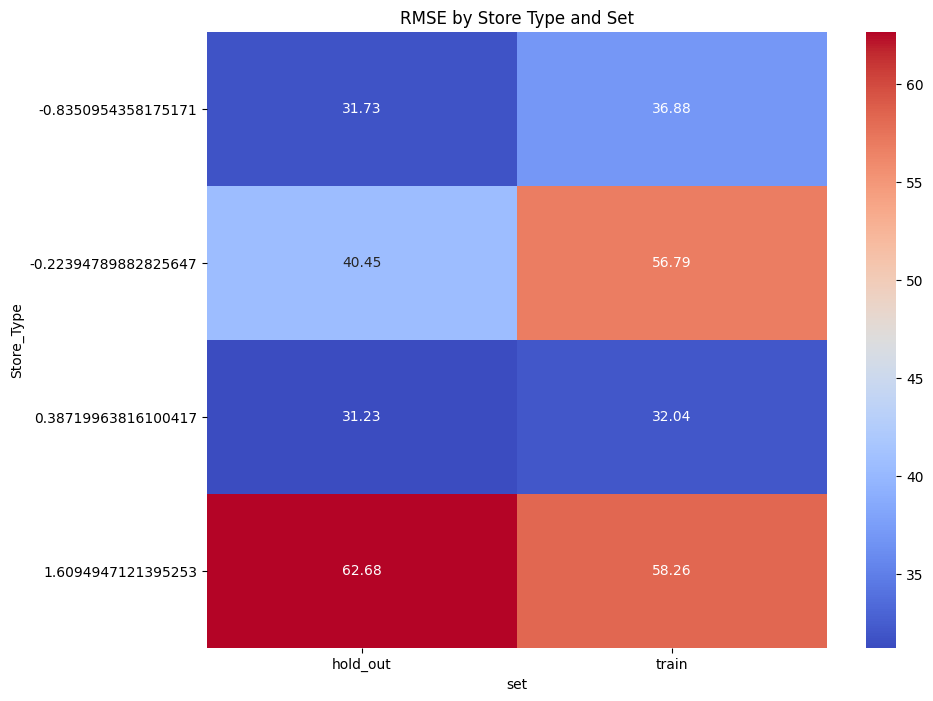

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

  # Function to calculate RMSE
def calculate_rmse(group):
    actual = group['Orders_original']
    predicted = group['Predicted_Orders']
    rmse = sqrt(mean_squared_error(actual, predicted))
    return rmse

  # Apply the function to each group
rmse_by_store_type_and_set = df_analysis.loc[df_analysis['Predicted_Orders'].notnull()].groupby(['Store_Type', 'set']).apply(calculate_rmse)

  # Reset the index of the Series to make it a DataFrame
rmse_df = rmse_by_store_type_and_set.reset_index()

  # Rename the 0 column to 'RMSE'
rmse_df = rmse_df.rename(columns={0: 'RMSE'})

  # Create a pivot table for the heatmap
pivot = rmse_df.pivot(index='Store_Type', columns='set', values='RMSE')

  # Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('RMSE by Store Type and Set')
plt.show()


In [80]:
import plotly.express as px
import plotly.graph_objects as go

plot_data = df_analysis.loc[df_analysis['Predicted_Orders'].notnull()]

samples = plot_data.loc[plot_data['set'] == 'hold_out']
samples = samples.sample(n=30)
samples_list = list(samples['Store_id'])

for store in samples_list:
  # Select the data for a specific store
  store_id = store  # replace with your store id
  df_store = plot_data[plot_data['Store_id'] == store_id]

  # Create a line plot of sales over time
  fig = px.line(df_store, x='Date', y='Orders_original', title='Sales Over Time for Store {}'.format(store_id))

  # Add a line for predicted sales
  fig.add_trace(go.Scatter(x=df_store['Date'], y=df_store['Predicted_Orders'], mode='lines', name='Predicted Orders'))

  fig.show()

In [81]:
plot_data['error'] = plot_data['Orders_original'] - plot_data['Predicted_Orders']

<ipython-input-81-dff4e64c1b6b>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [82]:
import plotly.express as px

# Assuming 'category' is the name of your category column
fig = px.histogram(plot_data, x="error", color="set", nbins=30,
                   labels={"error": "Error"},
                   title="Histogram of Error by Category",
                   template='plotly_white')

fig.show()
